In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
from time import time
import imageio

## Meshgrid

In [2]:
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y) 

## Random wave

In [3]:
def f_uniform(k):
    return 1/np.pi

In [4]:
def draw_from_hist(hist, bins, nsamples = 100000):
    cumsum = [0] + list(np.cumsum(hist))
    rand = np.random.rand(nsamples)*max(cumsum)
    return [np.interp(x, cumsum, bins) for x in rand]

In [5]:
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad)],
                     [2 * (bc - ad), aa + cc - bb - dd]])


# def sample_wave(r_grid, hist, bins, scale, t=0, f_omega=lambda x: 0, seed=None, n_wave = 100):
#     # set random seed
#     np.random.seed(seed=seed)
    
#     # initialize randomwave 
#     rho = np.zeros_like(r_grid[0]).astype('complex64')
#     r_grid = [r.astype(np.float32) for r in r_grid]
#     for i in range(n_wave):
#         # sample k
#         k_sample = np.array([draw_from_hist(hist, bins,1)[0],0])*scale

#         # rotate k
#         theta = np.random.rand()*2*np.pi
#         axis = [0,0,1]
#         R = rotation_matrix(axis,theta)
#         k_sample_rot = R@k_sample

#         # compute randomwave
#         k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(2)],axis=0)
#         omega_t = f_omega(k_sample_rot)*t
#         phi_r = np.random.rand()*2*np.pi-np.pi # random phase
#         rho_i = np.exp(1j*(k_dot_r + omega_t + phi_r)) # cos(k_n.r + phi_n)
#         rho += rho_i.astype('complex64')

#     rho = np.sqrt(2/n_wave)*rho
    
#     return rho

def sample_wave_vect(hist, bins, scale, seed=None, n_wave = 100):
    # set random seed
    np.random.seed(seed=seed)
    
    phi_r_list = []
    k_sample_rot_list = []
    for i in range(n_wave):
        # sample k
        k_sample = np.array([draw_from_hist(hist, bins,1)[0],0])*scale

        # rotate k
        theta = np.random.rand()*2*np.pi
        axis = [0,0,1]
        R = rotation_matrix(axis,theta)
        k_sample_rot = R@k_sample

        # compute randomwave
        phi_r = np.random.rand()*2*np.pi-np.pi # random phase
        phi_r_list.append(phi_r)
        k_sample_rot_list.append(k_sample_rot)
    
    return phi_r_list, k_sample_rot_list

def sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, t=0, f_omega=lambda x: 0):
    # initialize randomwave 
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    n_wave = len(phi_r_list)
    for i in range(n_wave):
        # compute randomwave
        k_sample_rot = k_sample_rot_list[i]
        phi_r = phi_r_list[i]
        omega_t = f_omega(k_sample_rot)*t
        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(2)],axis=0)
        
        rho_i = np.exp(1j*(k_dot_r + omega_t + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

In [6]:
k_list = np.arange(1000)/1000
bins = np.arange(1001)/1000
f_k_list = [f_uniform(k) for k in k_list]
t_list = np.arange(100)/100/2

def f_omega_deBroglie(k,D=1):
    k_norm = np.linalg.norm(k)
    return D*k_norm**2

def f_omega_em(k,c=1):
    k_norm = np.linalg.norm(k)
    return c*k_norm

feature_size = 0.5
scale = 2*np.pi/feature_size
amplitude = feature_size/4

phi_r_list, k_sample_rot_list = sample_wave_vect(f_k_list,bins=bins, scale=scale, 
                                                 seed = 114514, n_wave = 100)

In [16]:
Z_db_list = []
Z_em_list = []
for t in t_list:
    # Z = sample_wave_MO(r_grid,hist=f_k_list,bins=bins, scale=scale, f_omega=lambda x: f_omega_deBroglie(x,D=1), t=t,
    #                    seed = 114514, n_wave = 100)*amplitude
    
    Z_db = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, t=t, f_omega=lambda x: f_omega_deBroglie(x,D=0.5))*amplitude
    Z_em = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, t=t, f_omega=lambda x: f_omega_em(x,c=0.5*scale))*amplitude
    Z_db_list.append(np.real(Z_db))
    Z_em_list.append(np.real(Z_em))

(-1.0, 1.0)

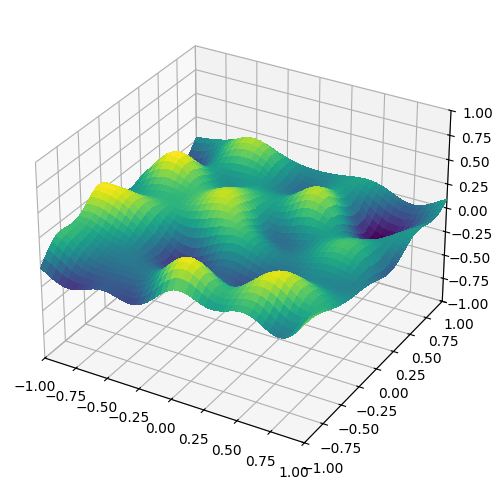

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,projection='3d')

Z = Z_db_list[0]
ax.plot_surface(r_grid[0], r_grid[1], Z, cmap=cm.viridis,
                    linewidth=0, antialiased=False)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

In [18]:
def gen_frames(Z_list):  
    frames = []
    
    # loop over your images
    for iZ, Z in enumerate(Z_list):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111,projection='3d')

        ax.plot_surface(r_grid[0], r_grid[1], Z, cmap=cm.viridis,
                            linewidth=0, antialiased=False)

        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        fig.canvas.draw()

        mat = np.array(fig.canvas.renderer._renderer)

        frames.append(mat)
        plt.close()

    return frames

In [19]:
frames = gen_frames(Z_db_list)
imageio.mimsave("./Figures/test_db.gif", frames, format='gif', loop=0, duration=1000/20)

frames = gen_frames(Z_em_list)
imageio.mimsave("./Figures/test_em.gif", frames, format='gif', loop=0, duration=1000/20)